In [1292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

First of all, we get the data from csv file. (expected return and covariance matrix)

In [1293]:
Eret = pd.read_csv("expected_return.csv").values
covariance = pd.read_csv("covariance_matrix.csv").values

We are looking to minimize the function:

$$ x^TCx - \beta x^T\mu$$

which $x^T$ is x array, C is the covariance matrix and $\mu$ is the Eret.

In [1294]:
def cost_func(x, beta):
    return x@covariance@np.transpose(x) - beta*(x*Eret).sum()

First of all, we get the data from csv file. (expected return and covariance matrix)

In [1295]:
def check(arr):
    arr_sum = sum(arr)
    normalized_arr = [max(0, float(element)/arr_sum) for element in arr]
    new_sum = sum(normalized_arr)
    normalized_arr = [element/new_sum for element in normalized_arr]
    
    return np.array(normalized_arr)

This is the selection function. We use tournament selection for this algorithm.

In tournament selection, we randomly pick 4 array from population and return the one that has the lowest cost.

In [1296]:
def tournament_selection(population, beta):
    m = 1000
    for i in range(4):
        random_index = np.random.randint(len(population))
        cost = cost_func(population[random_index], beta)
        if (cost < m):
            m = cost
            arr = population[random_index]
    return arr

crossover:

We use a random alpha and build two children like this:
$$ c_1(i) = alpha\times (p_1(i) + p_2(i))$$
$$ c_2(i) = (1-alpha)\times (p_1(i) + p_2(i)) $$

In [1297]:
def crossover(x, y):
    alpha = np.random.rand(1)
    
    c1 = np.zeros(10)
    c2 = np.zeros(10)
    
    for i in range(10):
        c1[i] = alpha*(x[i] + y[i])
        c2[i] = (1-alpha)*(x[i] + y[i])
        
    return c1, c2

In mutation, we pick a random number of indexes from 1 to 8 and then give that index, a random number between 0 and 0.5

In [1298]:
def mutation(x):
    num = np.random.randint(3, 11)
    for i in range(num):
        random_index = np.random.randint(10)
        x[random_index] = np.random.uniform(0, 1)
    return x

extra mutation is actully the SA algorithm. It finds the best neighbors and change it if better or in a certain situation:
$$ rand < e^{\frac{-(new cost - cost)}{\frac{1}{iteration}}} $$

In [1299]:
def extra_mutation(child, iteration, TL, beta):
    for i in range(TL):
        new_child = check(mutation(child))
        
        cost = cost_func(child, beta)
        new_cost = cost_func(new_child, beta)
        
        rand = np.random.random()
        if (new_cost < cost):
            child = new_child.copy()
        elif (rand < math.exp((cost - new_cost)/(10/iteration))):
            child = new_child.copy()
            
    return child

In this function, we sort ascending two array based on the first one (x).

In [1300]:
def double_sort(x, y):
    for i in range(len(x)):
        for j in range(i+1, len(x)):
            if (x[j] < x[i]):
                x[i], x[j] = x[j], x[i]
                t = y[i].copy()
                y[i] = y[j]
                y[j] = t
    return x, y

This is the main algorithm. This is exactly the genetic algorithm but instead of one mutation which might happen or not, we have the SA algorithm (extra mutation function).

In [1301]:
def genetic_SA(n, iterations, TL, replace_rate, crossover_chance, mutation_chance, beta):
    np.random.seed(100)
    
    population = np.array([[np.random.uniform(0, 1) for i in range(10)] for i in range(n)])
    
    for i in range(n):
        population[i] = check(population[i]).copy()
        
    cost_array = np.array([cost_func(population[i], beta) for i in range(n)])
    
    min_cost = 1000
    for i in range(len(cost_array)):
        if (cost_array[i] < min_cost):
            min_cost = cost_array[i]
            min_array = population[i]
            
    best_generation = np.array([])
            
    for i in range(iteration):
        child = np.empty((0, 10))
        
        for k in range(n//2):
            p1 = tournament_selection(population, beta)
            p2 = tournament_selection(population, beta)
            
            chance = np.random.rand()
            if (chance <= crossover_chance):
                c1, c2 = crossover(p1, p2)
                c1 = check(c1)
                c2 = check(c2)
            else:
                c1, c2 = p1, p2
            
            chance = np.random.rand()
            if(chance <= mutation_chance):
                c1 = check(extra_mutation(c1, i+1, TL, beta))
                c2 = check(extra_mutation(c2, i+1, TL, beta))
                 
            child = np.concatenate((child, [c1]))
            child = np.concatenate((child, [c2]))
            
        for k in range(n):
            child[k] = check(child[k]).copy()
            
        cost_array = np.array([cost_func(population[j], beta) for j in range(n)])
        cost_child = np.array([cost_func(child[j], beta) for j in range(n)])
        cost_array, population = double_sort(cost_array, population)
        cost_child, child = double_sort(cost_child, child)
            
        population = np.concatenate((population[:int(replace_rate*n)], child[:int((1-replace_rate)*n)]), axis=0)
        
        for k in range(n):
            population[k] = check(population[k]).copy()
            
        cost_array = np.append(cost_array[:int(replace_rate*n)], cost_child[:int((1-replace_rate)*n)])
        
        best_index = np.where(cost_array == min(cost_array))[0][0]
        best = cost_array[best_index]
        last_array = population[best_index].copy()
        best_generation = np.append(best_generation, best)
        
        if (best < min_cost):
            min_cost = best
            min_array = population[best_index].copy()
            
    return best_generation, min_array, last_array

Finally, a test for our algorithm.

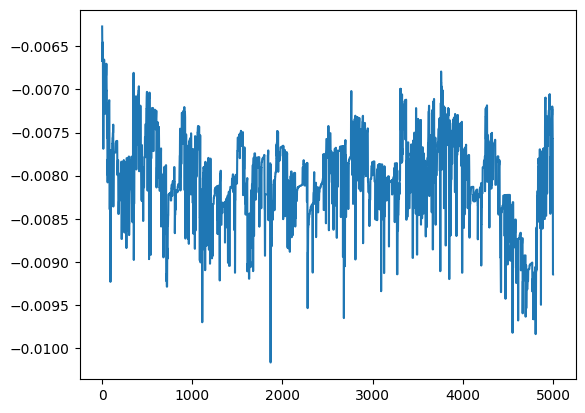

In [1302]:
iteration = 5000
arr, best_pos, last_pos = genetic_SA(100, iteration, 50, 0.5, 0.9, 0.9, 1) #n, iterations, TL, replace_rate, crossover_chance, mutation_chance, beta
ite = [i+1 for i in range(iteration)]
plt.plot(ite, arr)
plt.show()

In [1303]:
print(best_pos)
print(last_pos)

[4.19091053e-01 1.36893561e-04 2.28053135e-03 2.88919920e-02
 1.17424311e-03 4.70835543e-03 6.68813529e-03 4.59897749e-01
 7.23695804e-02 4.76146708e-03]
[0.29849953 0.03238907 0.02356739 0.03546195 0.00751786 0.00953657
 0.00629292 0.51621249 0.05493578 0.01558644]


In [1304]:
print((best_pos*Eret).sum())
print((last_pos*Eret).sum())

0.0164789871369023
0.015766788122961242


In [1305]:
print(best_pos@covariance@np.transpose(best_pos))
print(last_pos@covariance@np.transpose(last_pos))

0.0063119376393271686
0.006620441168746724


In [1306]:
print(best_pos.sum())
print(last_pos.sum())

1.0
0.9999999999999998


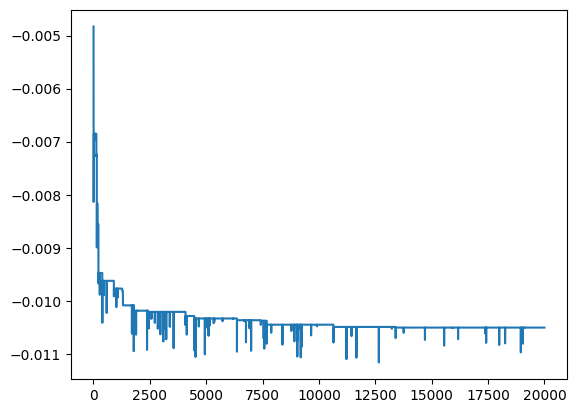

In [1353]:
iteration = 20000
arr, best_pos, last_pos = genetic_SA(20, iteration, 50, 0.6, 0.8, 0.5, 1) #n, iterations, TL, replace_rate, crossover_chance, mutation_chance, beta
ite = [i+1 for i in range(iteration)]
plt.plot(ite, arr)
plt.show()

In [1354]:
print(best_pos)
print(last_pos)

[3.23421142e-01 4.88855581e-05 1.22442055e-03 3.24594426e-03
 7.55482023e-04 4.99934237e-04 5.97782381e-04 3.18431122e-01
 3.50638414e-01 1.13687316e-03]
[4.21364397e-01 6.19333725e-05 1.55122489e-03 4.11230398e-03
 9.57124177e-04 6.33369333e-04 7.57333664e-04 5.37756713e-01
 3.13652896e-02 1.44031062e-03]


In [1355]:
print((best_pos*Eret).sum())
print((last_pos*Eret).sum())

0.014591600890106098
0.017364148837267626


In [1356]:
print(best_pos@covariance@np.transpose(best_pos))
print(last_pos@covariance@np.transpose(last_pos))

0.004768992019620203
0.006860502014629613


In [1357]:
print(best_pos.sum())
print(last_pos.sum())

1.0
1.0
